In [1]:
# Extensions for code formatting and inline plotting
%load_ext nb_black
#%matplotlib inline

<IPython.core.display.Javascript object>

In [2]:
# Library importing
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import os
import matplotlib.pyplot as plt
import pmdarima as pm

warnings.filterwarnings("ignore")  # Ignoring warnings to reduce text spam.

# Preferences
sns.set(rc={"figure.figsize": (15, 8.27)})
pd.set_option("display.float_format", "{:,}".format)
pd.set_option("display.max_columns", 30)
pd.set_option("display.max_rows", None)

<IPython.core.display.Javascript object>

In [3]:
# Data retrieval function
def retrieve_data():
    os.chdir('..')
    cwd = os.getcwd()
    if 'data' in os.listdir():
        os.chdir(cwd + '\\data')
        df = pd.read_csv('data.csv', sep=';', decimal=',')
        df['ds'] = pd.to_datetime(df[['year','month']].assign(day=1))
        df['y'] = df['quantity'].round().astype('int64')
        df.drop(columns=['year','month','quantity'], inplace=True)
        return df

<IPython.core.display.Javascript object>

In [4]:
# data object
df = retrieve_data()

<IPython.core.display.Javascript object>

In [5]:
df.head(20)

,ds,y
0,2010-01-01,10205914
1,2010-02-01,10390060
2,2010-03-01,12392784
3,2010-04-01,10876033
4,2010-05-01,12035571
5,2010-06-01,10134094
6,2010-07-01,9561953
7,2010-08-01,9845679
8,2010-09-01,12236500
9,2010-10-01,10949143


<IPython.core.display.Javascript object>

[Text(0.5, 0, 'time'),
 Text(0, 0.5, 'quantity'),
 Text(0.5, 1.0, 'Medicine sales over time')]

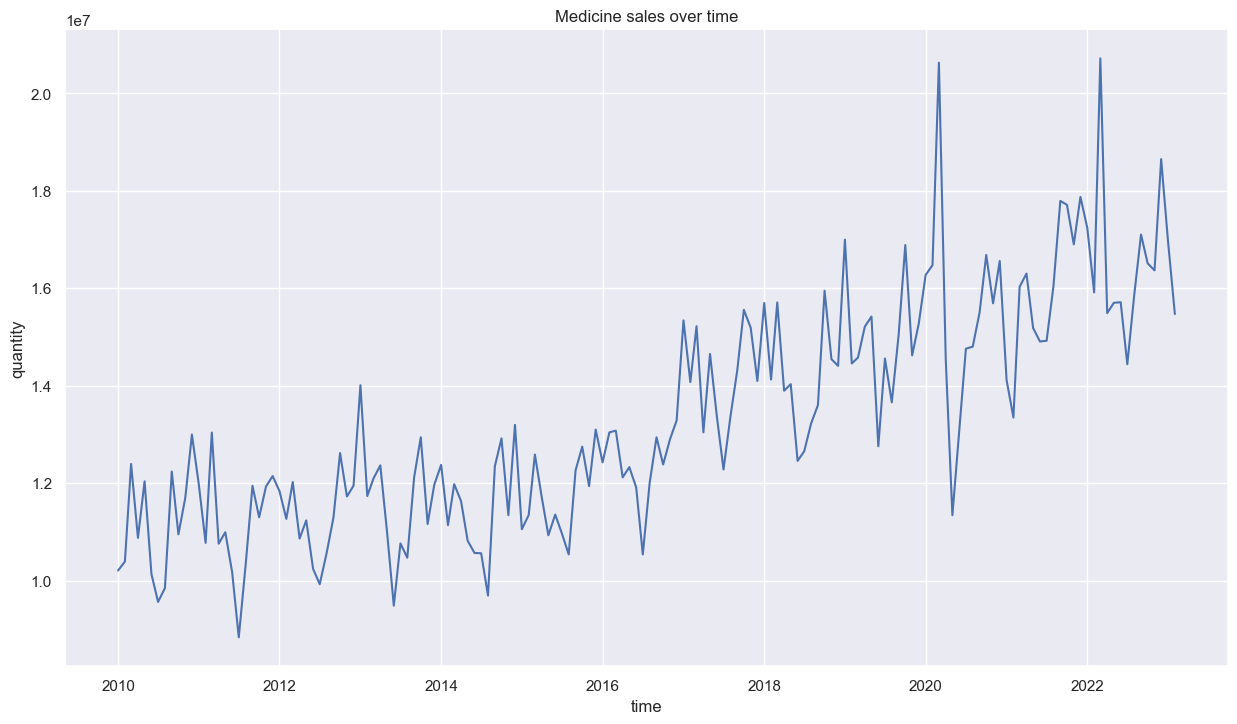

<IPython.core.display.Javascript object>

In [7]:
fig = sns.lineplot(df, x='ds', y='y')
fig.set(xlabel='time', ylabel='quantity', title='Medicine sales over time')

In [8]:
from prophet import Prophet

<IPython.core.display.Javascript object>

In [191]:
model = Prophet(seasonality_mode='multiplicative', yearly_seasonality=4, n_changepoints=50)
#model.add_country_holidays(country_name="LT")
model.fit(df)
future = model.make_future_dataframe(periods=60, freq='MS')
forecast = model.predict(future)

DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:TBB already found in load path
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: C:\Users\clawl\AppData\Local\Temp\tmp4eei2u27\6czlw0le.json
DEBUG:cmdstanpy:input tempfile: C:\Users\clawl\AppData\Local\Temp\tmp4eei2u27\9y63iw4q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\clawl\\final_project\\env\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=91533', 'data', 'file=C:\\Users\\clawl\\AppData\\Local\\Temp\\tmp4eei2u27\\6czlw0le.json', 'init=C:\\Users\\clawl\\AppData\\Local\\Temp\\tmp4eei2u27\\9y63iw4q.json', 'output', 'file=C:\\Users\\clawl\\AppData\\Local\\Temp\\tmp4eei2u27\\prophet_modelnv28mmjd\\prophet_model-20230315231219.csv', 'method=

<IPython.core.display.Javascript object>

In [192]:
forecast.tail(5).T

,213,214,215,216,217
ds,2027-10-01 00:00:00,2027-11-01 00:00:00,2027-12-01 00:00:00,2028-01-01 00:00:00,2028-02-01 00:00:00
trend,"19,970,696.12285516","20,024,412.380671587","20,076,395.855977807","20,130,112.113794234","20,183,828.371610664"
yhat_lower,"19,662,884.1754083","19,080,034.52868018","20,141,811.98321828","19,639,864.504104234","19,239,881.056112"
yhat_upper,"22,158,474.046642847","21,573,484.303325523","22,616,461.737748887","22,021,819.96262091","21,655,289.99186263"
trend_lower,"19,822,761.742528744","19,873,964.861013122","19,921,502.787974685","19,970,725.064287983","20,020,554.12036375"
trend_upper,"20,133,370.419589464","20,190,853.606687717","20,246,164.00743849","20,303,999.191090867","20,362,986.990908816"
multiplicative_terms,0.04947802520876532,0.01569350152546207,0.0643249675771576,0.034615614540991595,0.012132832872736254
multiplicative_terms_lower,0.04947802520876532,0.01569350152546207,0.0643249675771576,0.034615614540991595,0.012132832872736254
multiplicative_terms_upper,0.04947802520876532,0.01569350152546207,0.0643249675771576,0.034615614540991595,0.012132832872736254
yearly,0.04947802520876532,0.01569350152546207,0.0643249675771576,0.034615614540991595,0.012132832872736254


<IPython.core.display.Javascript object>

[[<matplotlib.lines.Line2D at 0x1c2031daa90>],

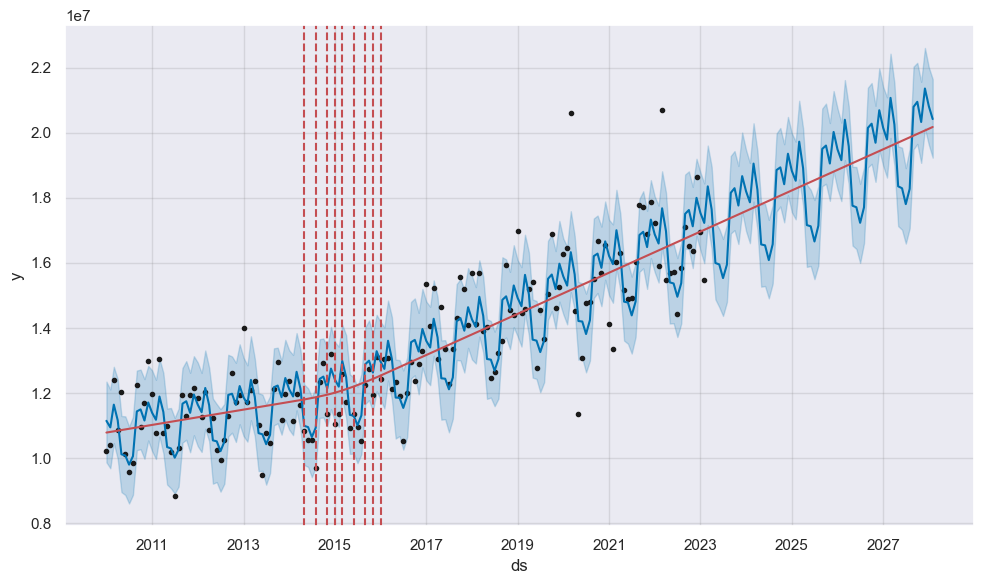

<IPython.core.display.Javascript object>

In [193]:
from prophet.plot import add_changepoints_to_plot
plt = model.plot(forecast)
add_changepoints_to_plot(plt.gca(), model, forecast)

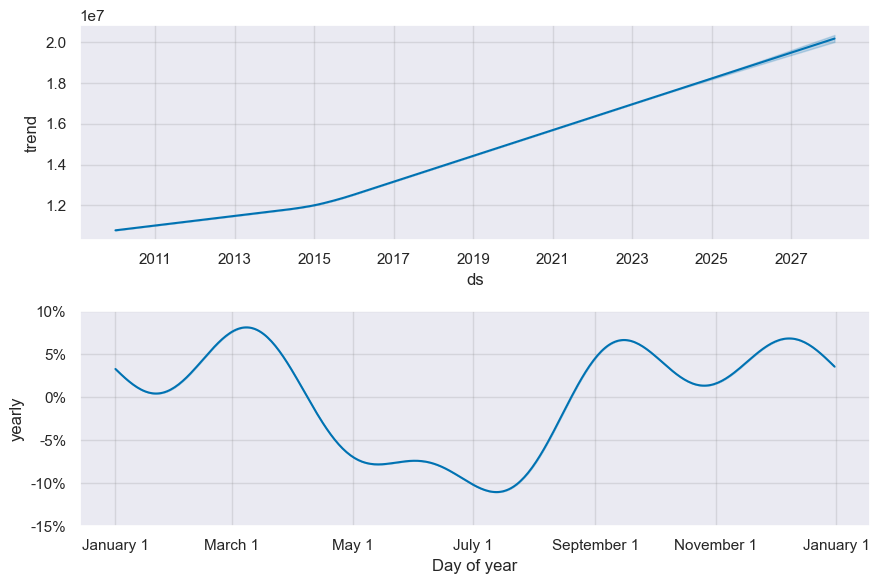

<IPython.core.display.Javascript object>

In [194]:
plt = model.plot_components(forecast)